Getting dataset, necessary imports


In [1]:
import numpy as np
import matplotlib.pyplot as plt 
np.set_printoptions(threshold=np.inf)
#Step 1: Load the training data
data = np.load('mnist.npz')
x_train = data['x_train']
y_train = data['y_train']
x_test = data['x_test']
y_test = data['y_test']
x_train = x_train.reshape(60000, 784)

Getting 100 samples from the data


In [2]:
#choosing 100 samples from each class in the training data
x_train_100 = []
y_train_100 = []
for i in range(10):
    x_train_100.append(x_train[y_train == i][:100])
    y_train_100.append(y_train[y_train == i][:100])
x_train_100 = np.array(x_train_100).reshape(1000, 784)
print(x_train_100.shape)
y_train_100 = np.array(y_train_100).reshape(1000, 1)
print(y_train_100.shape)

(1000, 784)
(1000, 1)


Removing mean

In [3]:
mean = np.mean(x_train_100, axis=0)
x_train_100 = x_train_100 - mean
print(x_train_100.shape)

(1000, 784)


Getting Covariance

In [4]:

cov = np.cov(x_train_100.T)/999
print(cov.shape)


(784, 784)


Eigenvalues, Eigenvectors

In [5]:
#Step 3: Calculate the eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(cov)

idx = eigenvalues.argsort()
idx = idx[::-1]#return the index of the decreasing sorted eigenvalues
eigenvalues = eigenvalues[idx]#sort the eigenvalues in decreasing order

#Step 4: Sort the eigenvevtors by decreasing eigenvalues
U = eigenvectors = eigenvectors[:,idx]
#drop the imaginary part of eigenvectors
U = np.real(U)
print(U.shape)
#eigenvectors[:,i] is the eigenvector corresponding to the eigenvalue eigenvalues[i].



(784, 784)


perform Y = U^T * X

In [6]:
#
Y = U.T @ x_train_100.T
print(Y.shape)

(784, 1000)


obtain reconstruction of the original data

In [7]:

Xrecon = U @ Y
print(Xrecon.shape)

(784, 1000)


MSE

In [8]:
#check MSE between the original data and the reconstructed data
MSE = np.mean((x_train_100 - Xrecon.T)**2)
print(MSE)


6.230646886544433e-23


Choosing p 

(1000, 784)
(1000, 28, 28)


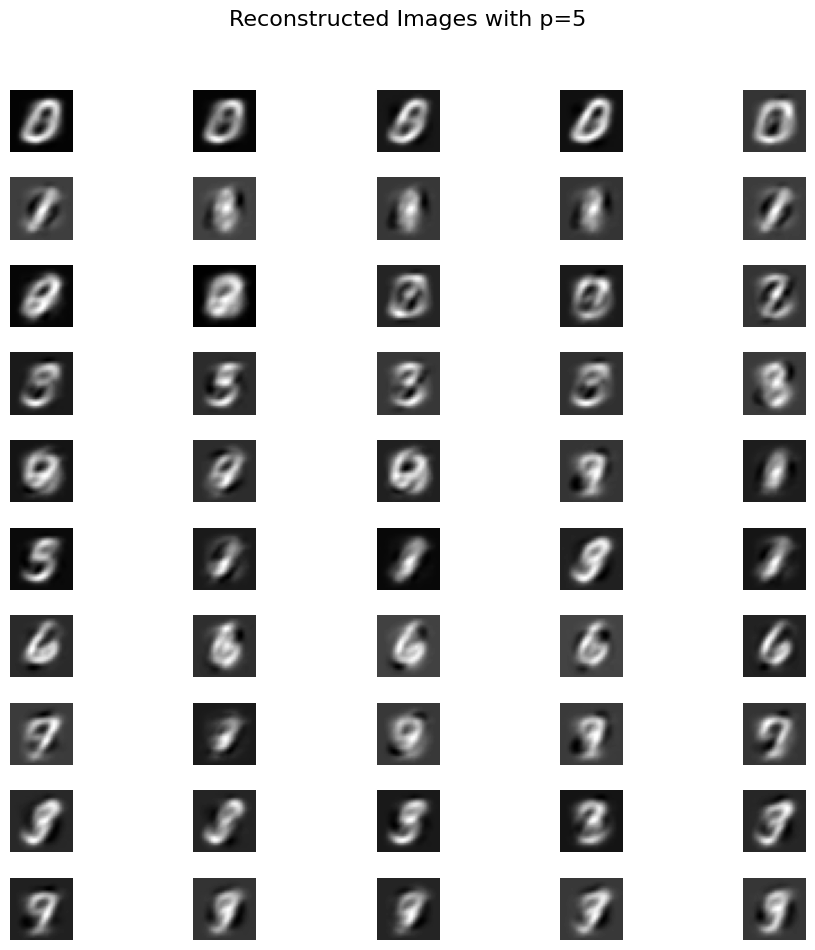

(1000, 784)
(1000, 28, 28)


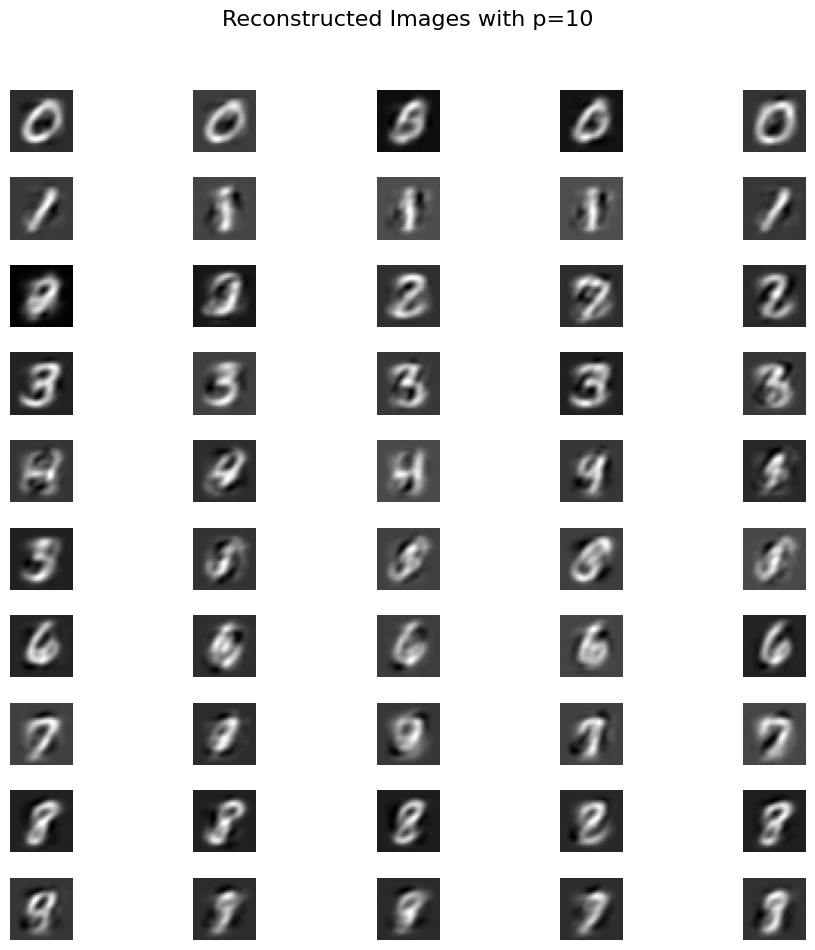

(1000, 784)
(1000, 28, 28)


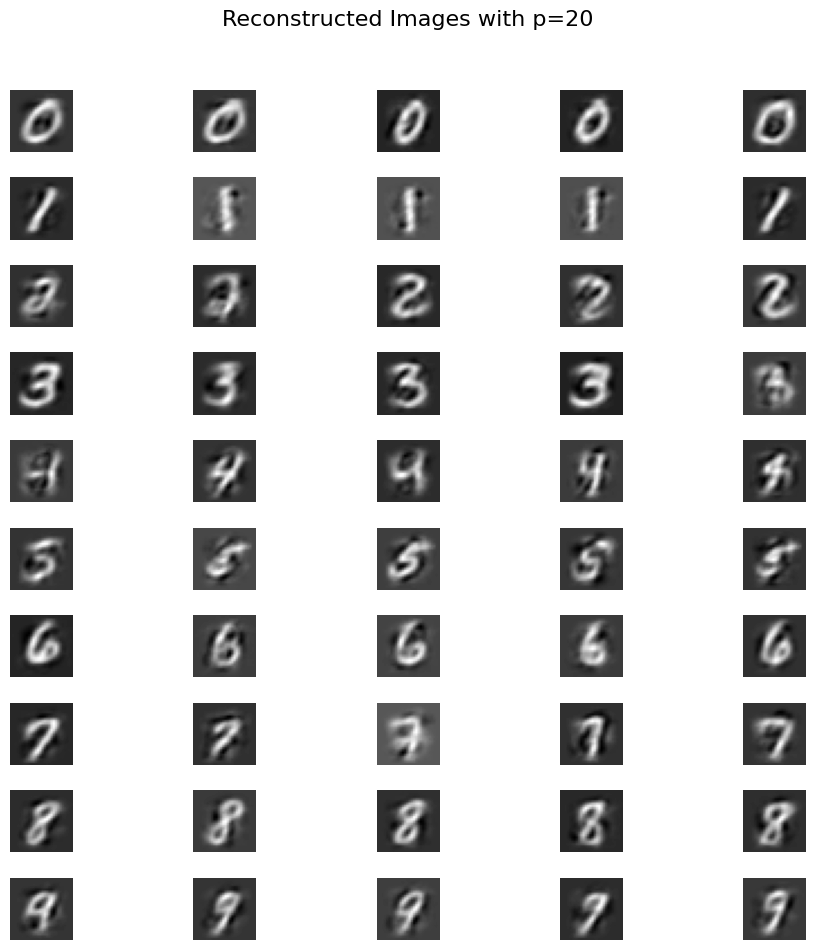

In [9]:
#Now chose p = 5, 10, 20 eigenvectors from U.
p = [5, 10, 20]
UpCollection = {}
#for each p obtain U_p and Y_p
for i in p:
    U_p = U[:, :i]
    UpCollection[i] = U_p
    Y_p = U_p.T @ x_train_100.T
    Xrecon_p = U_p @ Y_p
    # Add the mean back to the reconstructed data
    Xrecon_p = Xrecon_p.T + mean 

    print(Xrecon_p.shape)
    # Reshape the reconstructed data to 28x28
    Xrecon_p = Xrecon_p.reshape(1000, 28, 28)
    print(Xrecon_p.shape)
    # Plot reconstructed images
    plt.figure(figsize=(10, 10))
    plt.suptitle(f"Reconstructed Images with p={i}", fontsize=16)

    # Plot 5 reconstructed images from each class
    for j in range(10):
        for k in range(5):
            plt.subplot(10, 5, j * 5 + k + 1)
            plt.imshow(Xrecon_p[j * 100 + k], cmap='gray')
            plt.axis('off')

    plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.05, wspace=0.1, hspace=0.4)
    plt.show()
    


The QDA calculator for an individual sample

In [10]:
def qda(x, invcovs,constants, i,invsdotmeans):#returns the score based on the QDA model
    xtranspose = x.T
    xTWix = -0.5*np.dot(np.dot(xtranspose,invcovs[i]),x)
    witx = np.dot(invsdotmeans[i].T,x)
    return xTWix + witx + constants[i]

Applys QDA for a parameter p, corresponding eigenvector matrix U_p and the train and test data

NOTE!!: I AM RUNNING THE QDA ON THE COMPLETE TRAINSET WHICH IS OF 10000 SIZE. THIS YIELDS DIFFERENT ACCURACY FIGURES AS COMPARED TO RUNNING IT ON SMALLER BATCHES

In [11]:
def applyQda(p,X_train,X_test, U_p,classwise_accuracy_per_p):
    #project the training data onto the p dimensional space
    X_train_transposed = U_p.T @ X_train.T
    X_train_transposed = X_train_transposed.T
    #flatten X_test
    
    #project the test data onto the p dimensional space
    X_test_transposed = U_p.T @ X_test.T
    print(X_train_transposed.shape)
    
    priors = {i: np.sum(y_train == i) / len(y_train) for i in range(10)}
    means = [np.mean(X_train_transposed[y_train == i], axis=0) for i in range(10)]
    covs = [np.cov(X_train_transposed[y_train == i], rowvar=False) for i in range(10)]
    print(covs[0].shape)
    inv_covs = [np.linalg.pinv(cov) for cov in covs]
    log_dets = [np.linalg.slogdet(cov)[1] for cov in covs]
    constants = [-0.5*(np.dot(means[i].T,np.dot(inv_covs[i],means[i])))-0.5*log_dets[i] + np.log(priors[i]) for i in range(10)]
    invsdotmeans = [np.dot(inv_covs[i],means[i]) for i in range(10)]
    ypred = []
    for i in range(len(X_test)):
        scores = [qda(X_test_transposed.T[i], inv_covs,constants, j,invsdotmeans) for j in range(10)]
        ypred.append(scores.index(max(scores)))
    ypred = np.array(ypred)
    accuracy = np.mean(ypred == y_test) * 100
    #calculate class wise accuracy
    classwise_accuracy = {}
    for i in range(10):
        classwise_accuracy[i] = np.mean(ypred[y_test == i] == i) * 100
    classwise_accuracy_per_p[p] = classwise_accuracy
    return accuracy


#This code just generates it for p = [5,10,15,20,.......150] to visualise how accuracy compares against p value

[5, 10, 15, 20]
dict_keys([5, 10, 15, 20])
(60000, 5)
(5, 5)
Accuracy: 72.65 float64
(60000, 10)
(10, 10)
Accuracy: 89.69 float64
(60000, 15)
(15, 15)
Accuracy: 93.14 float64
(60000, 20)
(20, 20)
Accuracy: 94.63000000000001 float64
{5: {0: 88.26530612244898, 1: 96.29955947136564, 2: 79.16666666666666, 3: 79.20792079207921, 4: 64.76578411405295, 5: 54.82062780269058, 6: 87.16075156576201, 7: 77.62645914396887, 8: 44.04517453798768, 9: 49.85133795837463}, 10: {0: 95.91836734693877, 1: 97.26872246696036, 2: 89.34108527131784, 3: 90.0990099009901, 4: 87.67820773930754, 5: 87.4439461883408, 6: 93.73695198329854, 7: 88.61867704280155, 8: 81.93018480492813, 9: 83.74628344895937}, 15: {0: 97.85714285714285, 1: 97.00440528634361, 2: 94.28294573643412, 3: 93.16831683168317, 4: 93.89002036659878, 5: 91.14349775784754, 6: 95.09394572025052, 7: 89.00778210116731, 8: 89.21971252566735, 9: 90.18830525272547}, 20: {0: 98.36734693877551, 1: 97.18061674008811, 2: 94.96124031007753, 3: 94.95049504950495,

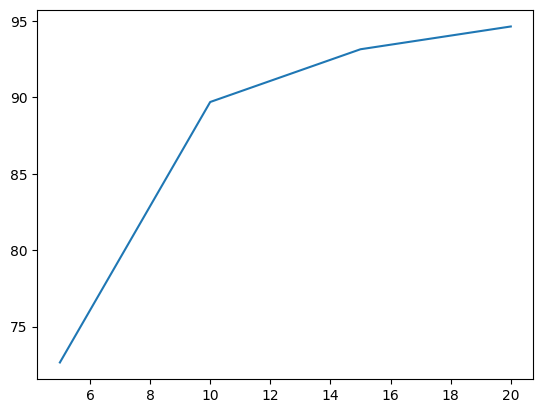

In [12]:
#just put the above functions over all p 
#and then plot the accuracy of the QDA model as a function of p
accuracy = []
plottablePs = [i*5 for i in range(1,5)]
print(plottablePs)
UpCollectionPlottable = {}

for i in plottablePs:
    U_p = U[:, :i]
    UpCollectionPlottable[i] = U_p
print(UpCollectionPlottable.keys())
#for each p obtain U_p and Y_p
#centralise x test 
x_test = x_test.reshape(10000, 784)
xmean = np.mean(x_test,axis=0)
#centralise x train
xtrainmean = np.mean(x_train)
x_train = x_train - mean
x_test = x_test - mean
classwise_accuracy_per_p = {}
for i in plottablePs:
    accuracy.append(applyQda(i,x_train,x_test,UpCollectionPlottable[i],classwise_accuracy_per_p))
plt.plot(plottablePs, accuracy)   
print(classwise_accuracy_per_p)